### Compute and store filtered and demodulated velocity fields at each grid point

In [1]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify


import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=1, cores=1,walltime='04:00:00') #processes=7, cores=7
w = cluster.scale(jobs=17
                 )
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.58:8787/status,
Dashboard: http://10.148.1.58:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.58:32795,Workers: 0
Dashboard: http://10.148.1.58:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

##### First step : Filter and demodulate for each face

In [15]:
# Load Eulerian fields
ds =  xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr',consolidated=False)
grd = ut.load_grd(consolidated=False)[['XC', 'YC', 'Depth']]#.persist()

In [6]:
#isel=dict(face=12) #face
#V = ['SSV_rot']#'zonal_velocity','meridional_velocity'
path = '/home1/datawork/zcaspar/mit4320/filtered_itide/'
dsel = 200

In [7]:
dt = 1/24 # time step in days

tidal_omega = sp.get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth
V = ['SSU_rot']

In [8]:
#dt = 1. # in hours
#T = 20
#omega = 1/30
#h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
#V = 'SSU_rot'

In [25]:
import dask
h = sp.generate_filter(om, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
def wrap_filter(_ds,dt=dt):
    
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
#    _ds = ut._reset_chunk_encoding(_ds)
    _ds = _ds.chunk(dict(time=-1,i=100,j=100))
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True)#.persist()
        ds_hat[v+'_hat_real'] = ds_hat[v+'_hat'].real
        ds_hat[v+'_hat_imag'] = ds_hat[v+'_hat'].imag
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])#.drop([v+'_hat',v+'_demodulated'])
#    ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat#.drop(['XC','YC'])

def wrap_filter_low(_ds,dt=dt):
    h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
    ds_hat = filt(_ds[v], h,hilbert=False)#.persist()
    ds_hat = ds_hat.rename(v+'_hat').to_dataset()
#    ds_hat = ds_hat.chunk(dict(i=4320//4,j=4320//4))
#    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [10]:
def wrap_demodulation(ds_hat,dt=dt):
#    time = np.arange(0,ds_hat['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)

#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=16,i=100,j=100))
#    ds_hat={}
    for v in V:
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat_real']+1j*ds_hat[v+'_hat_imag']
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()]).drop([v+'_demodulated',v+'_hat'])
 #   ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    
    return ds_hat#.drop(['XC','YC'])

In [19]:
#Select and rechunk (empirical) original dataset
isel = dict(face=slice(10,None))#dict(j=slice(3800,None))#j=slice(0,4320//10))
#dsp = ds.sel(j=slice(0,1000))
dsp = ds.sel(i=slice(0,None,4),j=slice(0,None,4))#j=slice(0,1000))
#.isel(i=slice(4,None,4),j=slice(4, None,4))#.isel(face=0)#.sel(**sel)#.persist()
dsp = dsp.chunk({"time": -1})#.persist()#,'i':100,'j':70
dsp

<xarray.Dataset>
Dimensions:  (face: 13, j: 1080, i: 1080, time: 8640)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * j        (j) int64 0 4 8 12 16 20 24 ... 4292 4296 4300 4304 4308 4312 4316
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-11-08T23:00:00
Data variables:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    SSU_rot  (time, face, j, i) float32 dask.array<chunksize=(8640, 1, 48, 144), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 270, 270), meta=np.ndarray>

In [30]:
dsp =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated.zarr',consolidated=False)#.isel(face=slice(1,None))
dsp = dsp.drop(['SSU_rot_demodulated_real','SSU_rot_demodulated_imag'])
dsp['SSU_rot_hat'] = dsp['SSU_rot_hat_real']+1j*dsp['SSU_rot_hat_imag']

In [12]:
time = np.arange(0,dsp['time'].values.size*dt,dt)
time

array([0.00000000e+00, 4.16666667e-02, 8.33333333e-02, ...,
       3.59875000e+02, 3.59916667e+02, 3.59958333e+02])

In [17]:
om,Tw,dband,V = omega,Tw,dband,V #define parameters needed in wrap_filter

In [42]:
dsp_cov =  xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_autocov.zarr',consolidated=False)#.isel(face=slice(1,None))

In [44]:
dsp_cov

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [26]:
# Apply wrap_filter on the dataset and store the result for each face (seperated)
import os
#zarr_main = os.path.join(ut.root_data_dir, "filtered_itide/SSU_filtered_face4.zarr")
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(dsp, 
                                        wrap_filter,
                                        overwrite=True,
                                        suffix="SSU_filtered.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        face=1
#                                        j=200
                                       )

13it [1:22:34, 381.12s/it]


In [38]:
ds_out

,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray
,Array,Chunk
Bytes,2.35 TiB,26.37 MiB
Shape,"(4320, 4320, 8640)","(100, 1080, 16)"
Count,95041 Tasks,95040 Chunks
Type,complex128,numpy.ndarray


In [108]:
ds_out

<xarray.Dataset>
Dimensions:                   (face: 4, j: 101, i: 101, time: 8640)
Coordinates:
  * face                      (face) int64 10 11 10 11
  * i                         (i) int64 3150 3151 3152 3153 ... 3248 3249 3250
  * j                         (j) int64 50 51 52 53 54 ... 146 147 148 149 150
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-11-08...
Data variables:
    SSU_rot_demodulated       (face, j, i, time) complex128 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>
    SSU_rot_demodulated_imag  (face, j, i, time) float64 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>
    SSU_rot_demodulated_real  (face, j, i, time) float64 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>
    SSU_rot_hat               (face, j, i, time) float64 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>
    SSU_rot_hat_imag          (face, j, i, time) float64 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>
    SSU_rot_hat_real          (face, j, i, time) float64 dask.array<chunksize=(1, 101, 101, 8640), meta=np.ndarray>

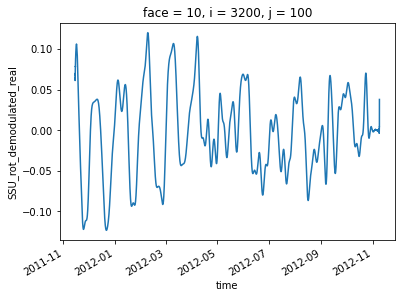

In [113]:
ds_out.isel(face=0).sel(i=3200,j=100).SSU_rot_demodulated_real.plot()

In [151]:
#client.restart()
#
cluster.close()

##### Second step : Concat filtered and demodulated fields

In [22]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()

#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=7, cores=7, walltime='04:00:00') #processes=7, cores=7 ,walltime='03:00:00'
w = cluster.scale(jobs=10
                 )
client = Client(cluster)

In [5]:
client

<Client: 'tcp://10.148.0.37:47279' processes=70 threads=70, memory=1.09 TiB>

In [6]:
ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_%s.zarr'%i, consolidated=False
                            ) for i in [1000,2000,3000,3800]],dim = 'j')#.persist()
#ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')

In [7]:
ds0 = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr').sel(j=slice(0,999))

In [8]:
ds = xr.concat([ds,ds0],dim='j')
ds

,Array,Chunk
Bytes,15.25 TiB,1.24 GiB
Shape,"(13, 4320, 4320, 8640)","(1, 192, 100, 8640)"
Count,73221 Tasks,21164 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,1.24 GiB
Shape,"(13, 4320, 4320, 8640)","(1, 192, 100, 8640)"
Count,73221 Tasks,21164 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [58]:
xr.merge([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_%s.zarr'%i, consolidated=False
                            ).isel(face=0) for i in [1000,2000]])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

KeyboardInterrupt: 

In [9]:
ds = ds.sortby('j')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  r

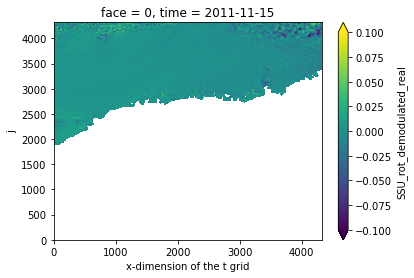

In [12]:
ds.SSU_rot_demodulated_real.isel(face=0,time=0).plot(cmap='viridis',vmax=0.1)

In [10]:
def merge(ds):
#    _ds = ds.chunk({'j':-1})
#
    _ds = ds
#    _ds = ds.chunk(dict(i=4320//4,j=4320//4)) #,j=4320//4
    
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [11]:
def rechunked(ds):
    _ds = ds.chunk({'i':4320//4}) #'time':16,
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [12]:
ds.chunks

Frozen({'face': (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1), 'j': (192, 192, 192, 192, 192, 40, 152, 152, 152, 152, 152, 152, 88, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 20), 'i': (100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 20), 'time': (8640,)})

In [13]:
ds = ds.isel(face=slice(8,None))
ds = ds.chunk({'time':-1,'j':100,'i':100})

In [14]:
ds

,Array,Chunk
Bytes,5.87 TiB,659.18 MiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,118585 Tasks,9680 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.87 TiB,659.18 MiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,118585 Tasks,9680 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [15]:
#Apply concat function on ds
face = 1
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds,#xr.merge([ds0,ds1]), 
                                        merge,
                                        overwrite=True,
                                        suffix="SSU_demodulated__.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=False,
                                        face=face
#                                        j=50
                                        )

5it [31:06, 373.32s/it]


In [16]:
ds_out

,Array,Chunk
Bytes,5.87 TiB,659.18 MiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,19365 Tasks,9680 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.87 TiB,659.18 MiB
Shape,"(5, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,19365 Tasks,9680 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


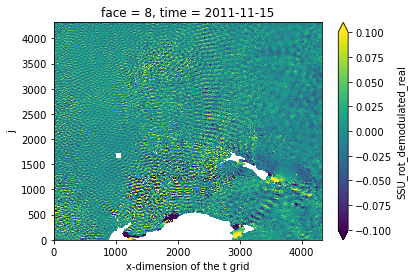

In [17]:
ds_out.SSU_rot_demodulated_real.isel(face=0,time=0).sortby(['i','j']).plot(cmap='viridis',vmax=0.1)

In [19]:
ds_out = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated_.zarr_%s'%i) for i in np.arange(0,8)],dim='face')
ds_out

,Array,Chunk
Bytes,9.39 TiB,659.18 MiB
Shape,"(8, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,30984 Tasks,15488 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,9.39 TiB,659.18 MiB
Shape,"(8, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,30984 Tasks,15488 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [21]:
_ds = xr.concat([xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated__.zarr_%s'%i) for i in np.arange(0,5)],dim='face')
ds_out = xr.concat([ds_out,_ds],dim='face')
ds_out

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,75517 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,75517 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [23]:
ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_demodulated.zarr')
ds

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [14]:
ds = ds.chunk({'i':1080,'j':1080,'time':16})

In [24]:
def rechunking(ds):
    _ds = ds.chunk({'i':1080,'j':1080})#,'time':16
    _ds = ut._reset_chunk_encoding(_ds)    
    return _ds

In [25]:
#Apply concat function on ds
face = 1
import os, dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_out, zarr = ut.custom_distribute(ds,#xr.merge([ds0,ds1]), 
                                        rechunking,
                                        overwrite=True,
                                        suffix="SSU_rechunked.zarr",
                                        tmp_dir=os.path.join(ut.root_data_dir, "filtered_itide"),
                                        append=True,
                                        face=face
#                                        j=50
                                        )

0it [01:40, ?it/s]


OSError: [Errno 12] Cannot allocate memory

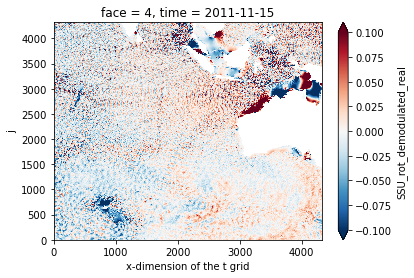

In [24]:
ds_out.SSU_rot_demodulated_real.isel(face=4,time=0).plot(vmax=0.1)

In [25]:
ds_out

,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,15.25 TiB,659.18 MiB
Shape,"(13, 4320, 4320, 8640)","(1, 100, 100, 8640)"
Count,25169 Tasks,25168 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [27]:
#client.restart()
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
